# Gesture Recognition


**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |



### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

### Understanding the Dataset:
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos.

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

Task is to train a model on the 'train' folder which performs well on the 'val' folder as well.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def getBatchData(source_path, t, batch, batch_size, img_idx,x,y,z):
    batch_data = np.zeros((batch_size,x,y,z,3)) # 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            resized_image = resize(image, (y, z), order=0)
            
            batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = resized_image[:,:,1]/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = resized_image[:,:,2]/255 #normalise and feed in the image
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [5]:
def generator(source_path, folder_list, batch_size):
    print('\n'+'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30)) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)  # x is the number of images you use for each video
    y, z = 128, 128 # (y,z) is the final size of the input images
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        
        # we iterate over the number of batches
        for batch in range(num_batches): 
            yield getBatchData(source_path, t, batch, batch_size, img_idx,x,y,z) #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_idx,x,y,z)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10



Source path =  /home/datasets/Project_data/train ; batch size = 5


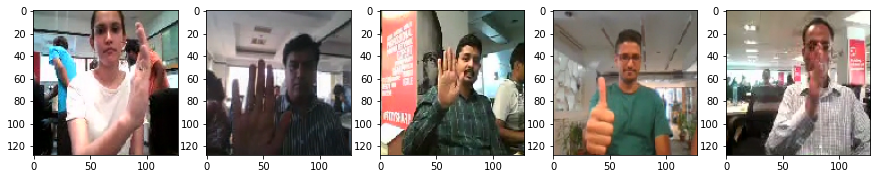

In [7]:
test_gen = generator(train_path, train_doc, batch_size=5)
batch_data, batch_labels=next(test_gen)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
axes[0].imshow(batch_data[0,15,:,:,:]) 
axes[1].imshow(batch_data[1,15,:,:,:]) 
axes[2].imshow(batch_data[2,15,:,:,:]) 
axes[3].imshow(batch_data[3,15,:,:,:]) 
axes[4].imshow(batch_data[4,15,:,:,:]) 

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

Let us create the `train_generator` and the `val_generator` which will be used in `model.fit()`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Let us create the `checkpoints` and the `ReduceLRonPlateau` which will be used in `model.fit()`.

In [10]:
model_name = 'model_init3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_').replace('.','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = num_epochs)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001) # write the ReduceLROnPlateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print('Steps per Epoch = ', steps_per_epoch, '; Validation Steps =', validation_steps)

Steps per Epoch =  21 ; Validation Steps = 4


In [12]:
def plotModelHistory(history):
    plt.figure(figsize=(20,6))
    ax1 = plt.subplot(121)
    ax1 = plt.plot(history.history['loss'])
    ax1 = plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    ax2 = plt.subplot(122)
    ax2 = plt.plot(history.history['categorical_accuracy'])
    ax2 = plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')

In [13]:
input_size = (30, 128, 128, 3)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Model-1 : Conv3D

In [14]:
#write your model here
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape= input_size), # input shape is (128x128x30)x3
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

2024-07-30 15:54:56.014938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-30 15:54:56.048011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-30 15:54:56.048376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-30 15:54:56.051938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-30 15:54:56.052302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = optimizers.Adam(learning_rate=0.1) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 32, 32, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 458752)            0         
                                                                 
 dense (Dense)               (None, 256)               1


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10


2024-07-29 12:30:41.668481: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2024-07-29 12:30:44.308890: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 9/21 [===========>..................] - ETA: 1:48 - loss: 227722.1719 - categorical_accuracy: 0.2153
Epoch 00001: saving model to model_init3_2024-07-2912_29_22_416240/model-00001.h5
19/21 [==========================>...] - ETA: 18s - loss: 107898.6641 - categorical_accuracy: 0.2253
Epoch 00001: saving model to model_init3_2024-07-2912_29_22_416240/model-00001.h5
21/21 [==============================] - ETA: 0s - loss: 98947.9297 - categorical_accuracy: 0.2262 
Source path =  /home/datasets/Project_data/val ; batch size = 32
21/21 [==============================] - 223s 11s/step - loss: 98947.9297 - categorical_accuracy: 0.2262 - val_loss: 1.6845 - val_categorical_accuracy: 0.1600 - lr: 0.1000
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:18 - loss: 1.6880 - categorical_accuracy: 0.1630
Epoch 00002: saving model to model_init3_2024-07-2912_29_22_416240/model-00002.h5
18/21 [========================>.....] - ETA: 18s - loss: 1.6704 - categorical_accuracy: 0.1715
Epoch 0000

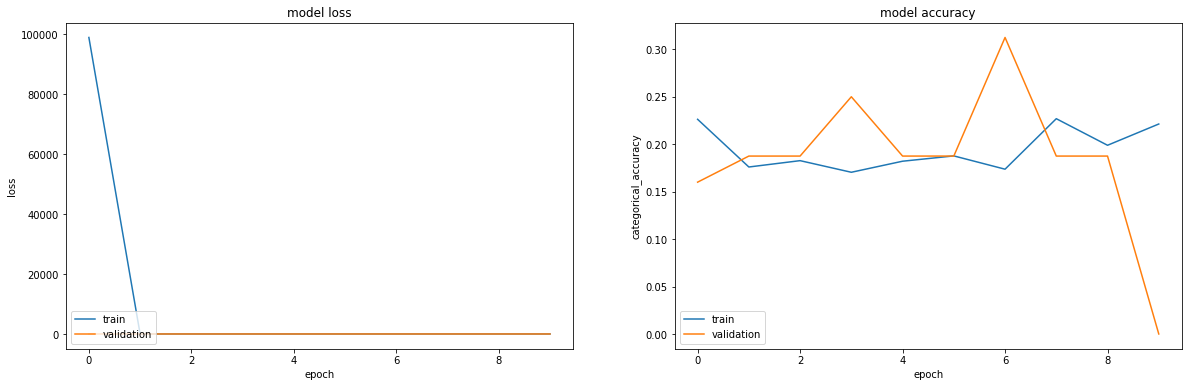

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: 1.6190 - categorical_accuracy: 0.2213 - val_loss: 1.6997 - val_categorical_accuracy: 0.0000e+00
- Changing Learning rate might have an effect in increasing model performance.

#### Changed Learning Rate from 0.1 to 0.001

In [16]:
#write your model here
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape= input_size), # input shape is (128x128x30)x3
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

In [17]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 30, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 15, 64, 64, 32)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 32, 32, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 458752)            0         
                                                                 
 dense_2 (Dense)             (None, 256)              

Epoch 1/10
 9/21 [===========>..................] - ETA: 56s - loss: 14.8077 - categorical_accuracy: 0.2418 
Epoch 00001: saving model to model_init3_2024-07-2912_29_22_416240/model-00001.h5
19/21 [==========================>...] - ETA: 9s - loss: 7.8462 - categorical_accuracy: 0.2539 
Epoch 00001: saving model to model_init3_2024-07-2912_29_22_416240/model-00001.h5
21/21 [==============================] - 104s 5s/step - loss: 7.2463 - categorical_accuracy: 0.2689 - val_loss: 1.5006 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:00 - loss: 1.5316 - categorical_accuracy: 0.3750
Epoch 00002: saving model to model_init3_2024-07-2912_29_22_416240/model-00002.h5
18/21 [========================>.....] - ETA: 14s - loss: 1.4325 - categorical_accuracy: 0.4183
Epoch 00002: saving model to model_init3_2024-07-2912_29_22_416240/model-00002.h5
21/21 [==============================] - 104s 5s/step - loss: 1.4378 - categorical_accuracy: 0.4

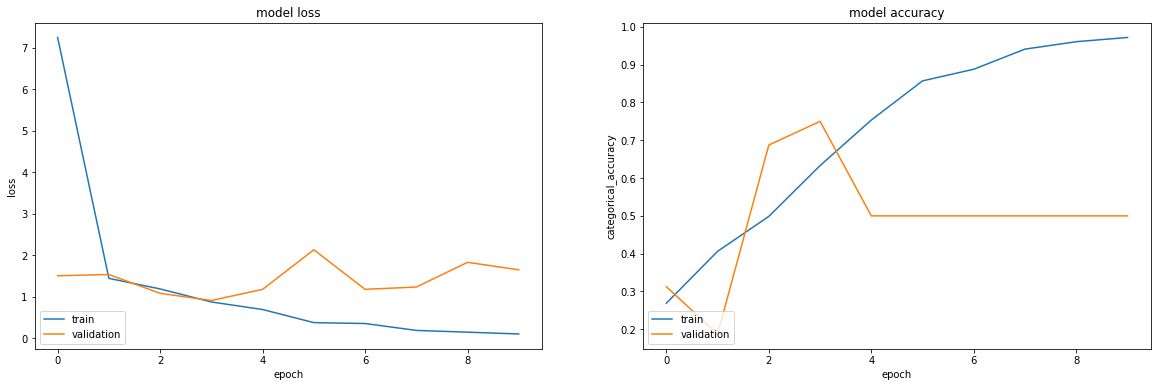

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is better.
- Model performance in final epoch: loss: 0.0970 - categorical_accuracy: 0.9720 - val_loss: 1.6437 - val_categorical_accuracy: 0.5000
- Seems like model is overfitting. Adding more layers might help increase model's validation accuracy or help both accuracy metrics to move closer.

### Model-2 : Conv3D with more Layers

In [18]:
#write your model here
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape= input_size), # input shape is (128x128x30)x3
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(256, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

In [19]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 64, 64, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 7, 32, 32, 64)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 7, 32, 32, 128)    221312    
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 3, 16, 16, 128)  

Epoch 1/10
 8/21 [==========>...................] - ETA: 58s - loss: 1.0145 - categorical_accuracy: 0.5588 
Epoch 00001: saving model to model_init3_2024-07-2912_29_22_416240/model-00001.h5
18/21 [========================>.....] - ETA: 13s - loss: 1.0037 - categorical_accuracy: 0.5719
Epoch 00001: saving model to model_init3_2024-07-2912_29_22_416240/model-00001.h5
21/21 [==============================] - 99s 5s/step - loss: 0.9857 - categorical_accuracy: 0.5854 - val_loss: 0.7305 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/10
 7/21 [=========>....................] - ETA: 1:08 - loss: 0.8096 - categorical_accuracy: 0.7311
Epoch 00002: saving model to model_init3_2024-07-2912_29_22_416240/model-00002.h5
17/21 [=======================>......] - ETA: 18s - loss: 0.8087 - categorical_accuracy: 0.7024
Epoch 00002: saving model to model_init3_2024-07-2912_29_22_416240/model-00002.h5
21/21 [==============================] - 101s 5s/step - loss: 0.8285 - categorical_accuracy: 0.683

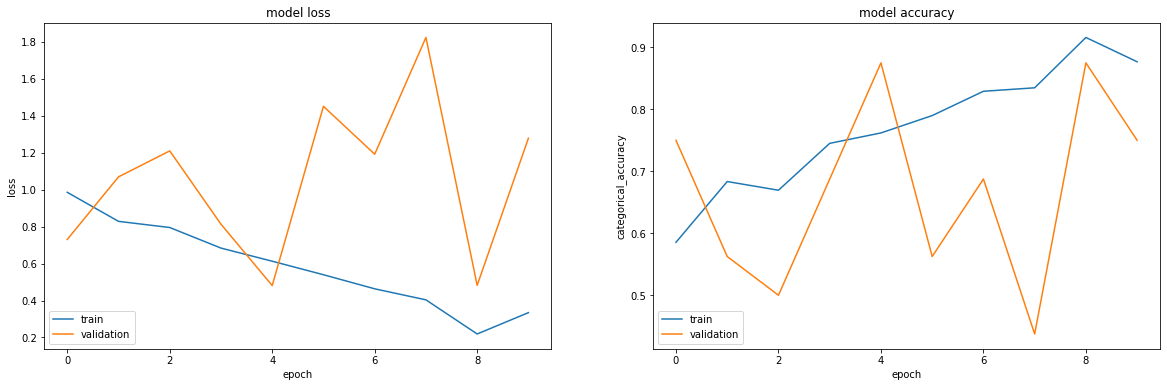

In [22]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is good
- Model performance in final epoch: loss: 0.3342 - categorical_accuracy: 0.8768 - val_loss: 1.2787 - val_categorical_accuracy: 0.7500
- Since adding more layers helped both accuracy metric to move closer, adding normalization layes might improve performance.

### Model-3 : Conv3D with BatchNormalization

In [20]:
#write your model here
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape= input_size),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Conv3D(256, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

In [21]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 64, 64, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 15, 64, 64, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 32, 32, 64)    0         
 3D)                                                             
                                                      


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10


2024-07-29 14:08:34.593799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


 9/21 [===========>..................] - ETA: 1:38 - loss: 5.4795 - categorical_accuracy: 0.3611
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 16s - loss: 3.5706 - categorical_accuracy: 0.4178
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - ETA: 0s - loss: 3.3384 - categorical_accuracy: 0.4329
Source path =  /home/datasets/Project_data/val ; batch size = 32
21/21 [==============================] - 206s 10s/step - loss: 3.3384 - categorical_accuracy: 0.4329 - val_loss: 49.2010 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:14 - loss: 0.9272 - categorical_accuracy: 0.6793
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 18s - loss: 1.3470 - categorical_accuracy: 0.6256
Epoch 00002: saving model to

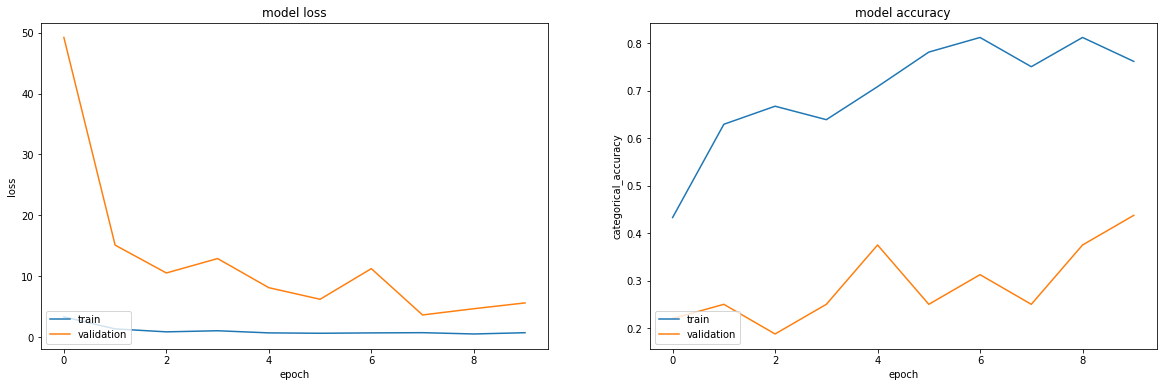

In [17]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: 0.1689 - categorical_accuracy: 0.9328 - val_loss: 2.1235 - val_categorical_accuracy: 0.4375
- It is also clearly overfitting. Maybe adding droput will increase the performance

### Model-4 : Conv3D with Batch Normalization and Dropouts

In [22]:
#write your model here
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape= input_size), 
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv3D(256, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

In [23]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 64, 64, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 15, 64, 64, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 15, 64, 64, 32)    0         
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 7, 32, 32, 64)   

Epoch 1/10
 9/21 [===========>..................] - ETA: 56s - loss: 4.8521 - categorical_accuracy: 0.3203 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 9s - loss: 3.5978 - categorical_accuracy: 0.3715 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - 103s 5s/step - loss: 3.4097 - categorical_accuracy: 0.3782 - val_loss: 33.2826 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:00 - loss: 1.5914 - categorical_accuracy: 0.5000
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 13s - loss: 1.4574 - categorical_accuracy: 0.5654
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
21/21 [==============================] - 99s 5s/step - loss: 1.4423 - categorical_accuracy: 0.55

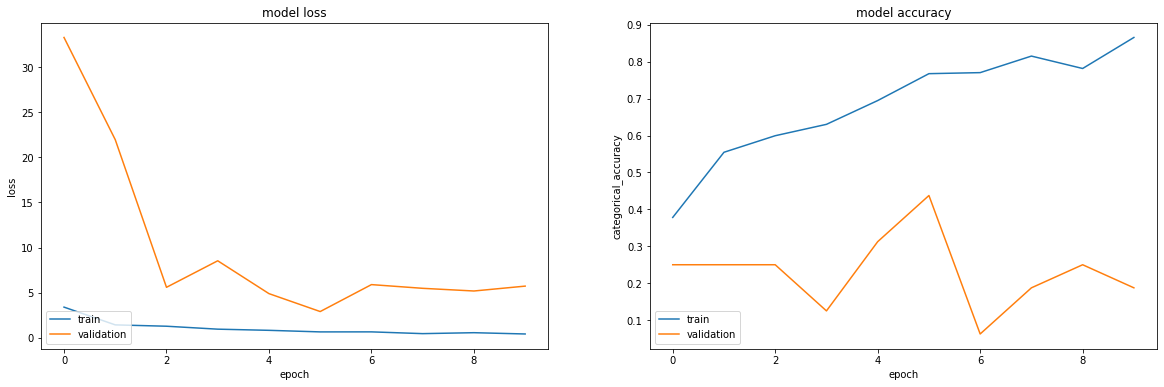

In [20]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: 0.4345 - categorical_accuracy: 0.8655 - val_loss: 5.7360 - val_categorical_accuracy: 0.1875
- Changing dropout value might help in increasing model performance.

#### Change Dropout from 0.2 to 0.5

In [24]:
#write your model here
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape= input_size), 
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv3D(256, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.5),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

In [25]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 64, 64, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 15, 64, 64, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 15, 64, 64, 32)    0         
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 7, 32, 32, 64)   

Epoch 1/10
 9/21 [===========>..................] - ETA: 54s - loss: 4.1285 - categorical_accuracy: 0.3529
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 8s - loss: 3.3473 - categorical_accuracy: 0.3870 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - 96s 5s/step - loss: 3.1697 - categorical_accuracy: 0.4006 - val_loss: 7.5352 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:01 - loss: 1.4075 - categorical_accuracy: 0.5000
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 13s - loss: 1.3189 - categorical_accuracy: 0.5588
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
21/21 [==============================] - 98s 5s/step - loss: 1.3932 - categorical_accuracy: 0.5630 

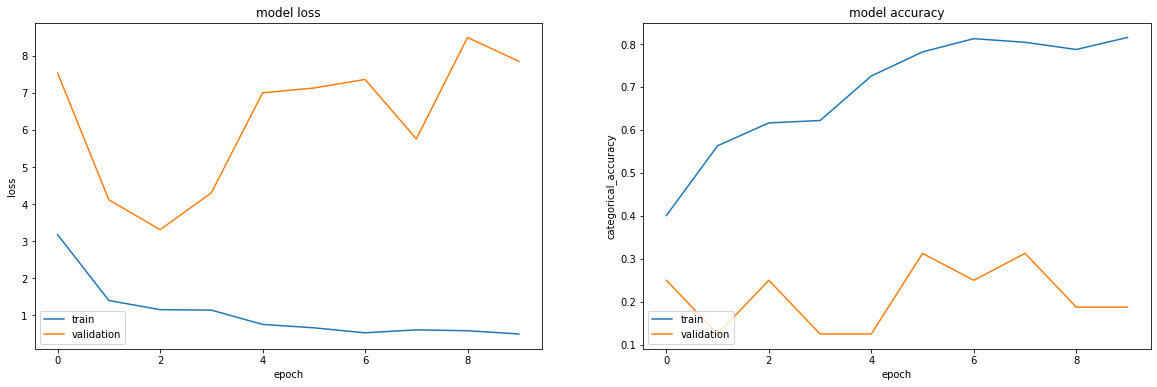

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: 0.4895 - categorical_accuracy: 0.8151 - val_loss: 7.8532 - val_categorical_accuracy: 0.1875
- Conv3D are not giving good results. Changing Architecture might help.

### Model-5 : Conv2d with LSTM

In [26]:
#write your model here
model = Sequential([
    TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'), input_shape=input_size),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),
    LSTM(256),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

In [27]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 128, 128, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 64, 64, 32)  

Epoch 1/10
 9/21 [===========>..................] - ETA: 56s - loss: 1.5074 - categorical_accuracy: 0.3137 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 9s - loss: 1.4068 - categorical_accuracy: 0.4025 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - 103s 5s/step - loss: 1.3820 - categorical_accuracy: 0.4090 - val_loss: 1.7600 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 59s - loss: 1.3936 - categorical_accuracy: 0.3897 
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 13s - loss: 1.2178 - categorical_accuracy: 0.4608
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
21/21 [==============================] - 100s 5s/step - loss: 1.1984 - categorical_accuracy: 0.48

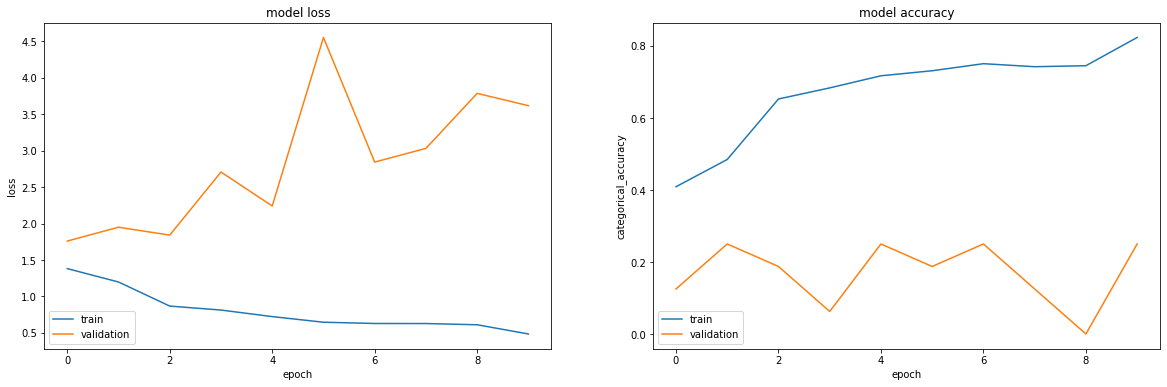

In [25]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: loss: 0.4846 - categorical_accuracy: 0.8235 - val_loss: 3.6187 - val_categorical_accuracy: 0.2500
- Adding Droputs rate might have an effect in increasing model performance.

### Model-6 : Conv2d with LSTM and Dropouts

In [28]:
#write your model here
model = Sequential([
    TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'), input_shape=input_size),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
])

In [29]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 128, 128, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 128, 128, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 64, 64, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 64, 64, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 64, 64, 32)  

Epoch 1/10
 9/21 [===========>..................] - ETA: 1:00 - loss: 1.6090 - categorical_accuracy: 0.2549
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 9s - loss: 1.5037 - categorical_accuracy: 0.3189 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - 114s 6s/step - loss: 1.4840 - categorical_accuracy: 0.3305 - val_loss: 1.6971 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:01 - loss: 1.2280 - categorical_accuracy: 0.4485
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 14s - loss: 1.2289 - categorical_accuracy: 0.4771
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
21/21 [==============================] - 108s 5s/step - loss: 1.2265 - categorical_accuracy: 0.47

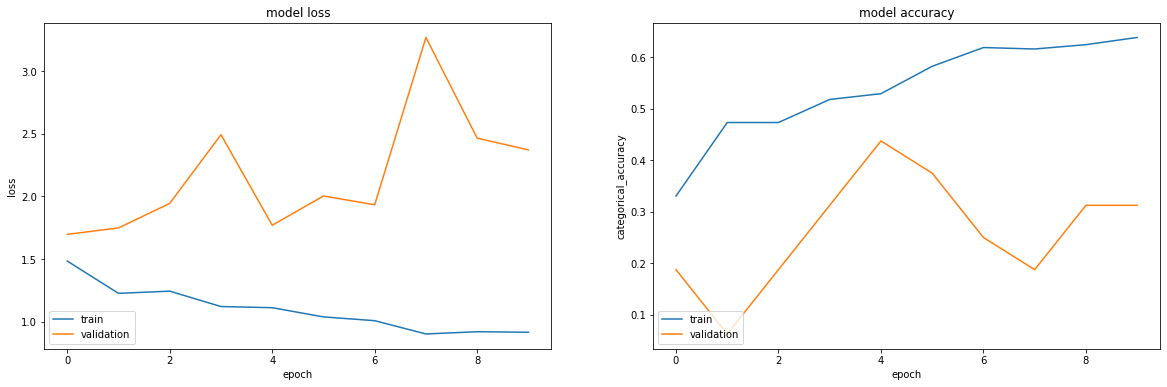

In [27]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: 0.9161 - categorical_accuracy: 0.6387 - val_loss: 2.3710 - val_categorical_accuracy: 0.3125
- Changing architecture might have an effect in increasing model performance.

### Model-7 : Conv2d with ConvLSTM2D

In [30]:
#write your model here
model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_size),
    BatchNormalization(),
    
    TimeDistributed(Conv2D(16, (3,3), activation='relu')),
    BatchNormalization(),
    
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
    BatchNormalization(),
    
    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),
    
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
    ])

In [31]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 30, 126, 126, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_22 (Bat  (None, 30, 126, 126, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_33 (TimeDi  (None, 30, 124, 124, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_23 (Bat  (None, 30, 124, 124, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 122, 122, 8)      

Epoch 1/10
 9/21 [===========>..................] - ETA: 1:20 - loss: 1.5726 - categorical_accuracy: 0.2745
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 14s - loss: 1.5472 - categorical_accuracy: 0.3034
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - 154s 7s/step - loss: 1.5402 - categorical_accuracy: 0.3109 - val_loss: 1.5977 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:26 - loss: 1.3972 - categorical_accuracy: 0.4412
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 21s - loss: 1.3745 - categorical_accuracy: 0.4673
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
21/21 [==============================] - 149s 7s/step - loss: 1.3606 - categorical_accuracy: 0.47

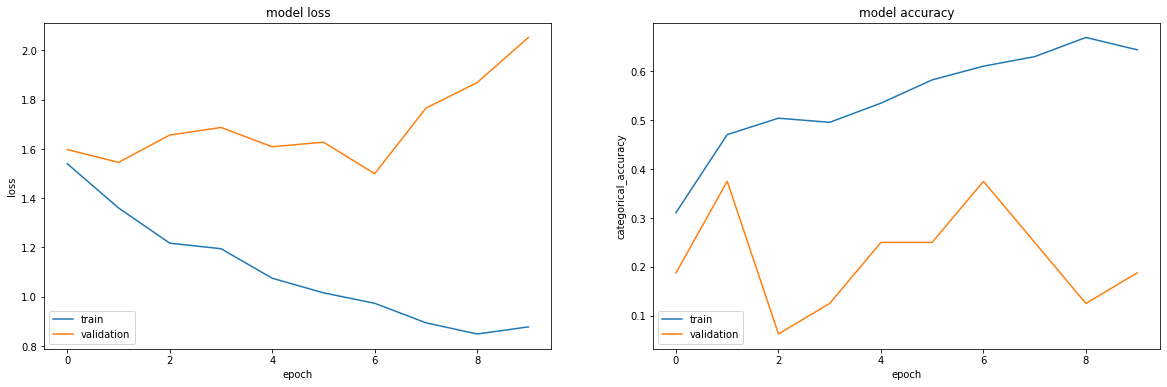

In [29]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: 0.8776 - categorical_accuracy: 0.6443 - val_loss: 2.0527 - val_categorical_accuracy: 0.1875
- Let us try the experiment with GRU

### Model-8 : Conv2d with GRU

In [32]:
#write your model here
model = Sequential([
    TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'), input_shape=input_size),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),
    GRU(256),

    Dense(256, activation='relu'),

    Dense(5, activation='softmax')
])

In [33]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 30, 128, 128, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 30, 128, 128, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 30, 64, 64, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 30, 64, 64, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 30, 64, 64, 32)  

Epoch 1/10
 9/21 [===========>..................] - ETA: 1:00 - loss: 1.6278 - categorical_accuracy: 0.2876
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 10s - loss: 1.4120 - categorical_accuracy: 0.3808
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - 123s 6s/step - loss: 1.4009 - categorical_accuracy: 0.3866 - val_loss: 1.7399 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:14 - loss: 0.9933 - categorical_accuracy: 0.5809
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 16s - loss: 0.9354 - categorical_accuracy: 0.6242
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
21/21 [==============================] - 117s 6s/step - loss: 0.9420 - categorical_accuracy: 0.60

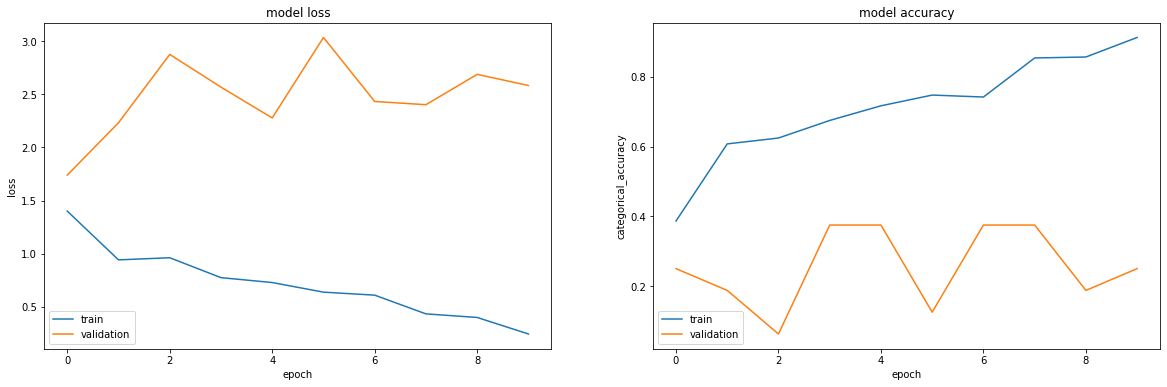

In [31]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: 0.2444 - categorical_accuracy: 0.9132 - val_loss: 2.5835 - val_categorical_accuracy: 0.2500
- Let us try the experiment with GRU and dropouts if model performancce inscreases.

### Model-9 : Conv2d with GRU and Dropouts

In [34]:
#write your model here
model = Sequential([
    TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'), input_shape=input_size),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
])

In [35]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_51 (TimeDi  (None, 30, 128, 128, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 30, 128, 128, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 30, 64, 64, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 30, 64, 64, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 30, 64, 64, 32) 

Epoch 1/10
 9/21 [===========>..................] - ETA: 55s - loss: 1.5001 - categorical_accuracy: 0.3595 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 9s - loss: 1.4761 - categorical_accuracy: 0.3994 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - 104s 5s/step - loss: 1.4687 - categorical_accuracy: 0.3922 - val_loss: 2.4815 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:01 - loss: 1.2646 - categorical_accuracy: 0.4632
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 13s - loss: 1.1428 - categorical_accuracy: 0.5196
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
21/21 [==============================] - 104s 5s/step - loss: 1.1355 - categorical_accuracy: 0.52

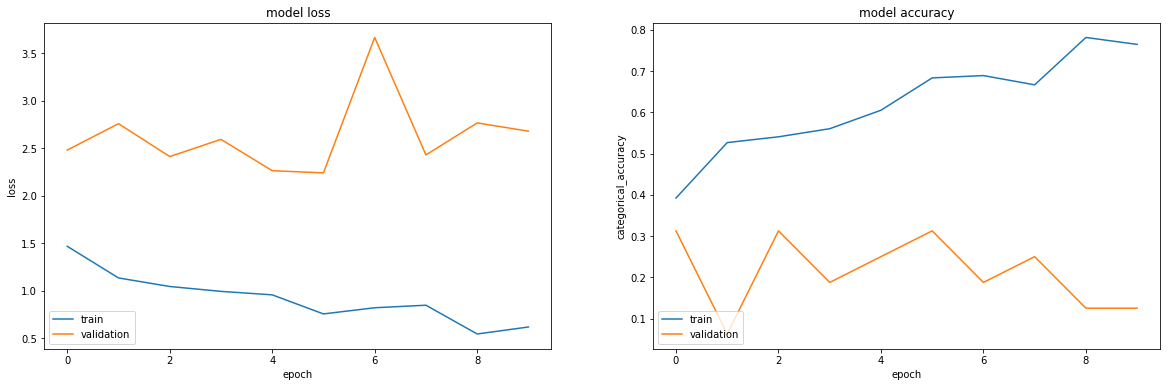

In [33]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model is not performing good
- Model performance in final epoch: loss: 0.6194 - categorical_accuracy: 0.7647 - val_loss: 2.6804 - val_categorical_accuracy: 0.1250
- We see that the model Overfits in Training data but fails in Validation data. Using Transfer Learning should give us best model performance.

We see that the model Overfits in Training data but fails in Validation data

### Model-10 : Using Transfer Learning (MobileNet) 

In [36]:
#write your model here
mobilenet = keras.applications.MobileNet(weights='imagenet', include_top=False)

model = Sequential([
    TimeDistributed(mobilenet, input_shape=input_size)
])

for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

In [37]:
optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_67 (TimeDi  (None, 30, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 30, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 30, 4096)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)             

Epoch 1/10
 9/21 [===========>..................] - ETA: 52s - loss: 1.5456 - categorical_accuracy: 0.3203
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
19/21 [==========================>...] - ETA: 9s - loss: 1.4679 - categorical_accuracy: 0.3684 
Epoch 00001: saving model to model_init3_2024-07-2914_06_41_977967/model-00001.h5
21/21 [==============================] - 105s 5s/step - loss: 1.4562 - categorical_accuracy: 0.3754 - val_loss: 1.0458 - val_categorical_accuracy: 0.6875 - lr: 0.0010
Epoch 2/10
 8/21 [==========>...................] - ETA: 1:06 - loss: 1.2323 - categorical_accuracy: 0.4926
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
18/21 [========================>.....] - ETA: 15s - loss: 1.1296 - categorical_accuracy: 0.5490
Epoch 00002: saving model to model_init3_2024-07-2914_06_41_977967/model-00002.h5
21/21 [==============================] - 114s 6s/step - loss: 1.0734 - categorical_accuracy: 0.591

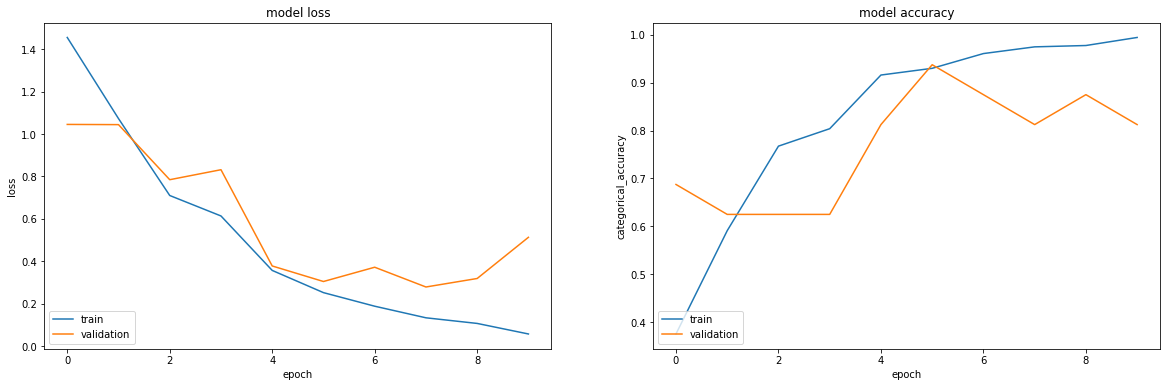

In [35]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(history)

Observation:
- Model performs good in both Training data and validation data.
- Model performance in final epoch: loss: loss: 0.0568 - categorical_accuracy: 0.9944 - val_loss: 0.5130 - val_categorical_accuracy: 0.8125
- Best Model at Epoch 6: Training Accuracy: 93% and  Validation Accuracy: 93.7%